In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/kaggle/input/pfizer-vaccine-tweets/vaccination_tweets.csv")
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [4]:
#check the null values
df.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [5]:
#remove irrelevant features
df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1, inplace=True)


In [6]:
df

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...
...,...
11015,"The number of Covid-19 cases today, 17 Novembe..."
11016,First dose ✅\n#PfizerBioNTech
11017,"The number of Covid-19 cases today, 16 Novembe..."
11018,#PfizerBioNTech has developed new pill #Paxlov...


In [7]:
df['text'].iloc[2]

'#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P'

In [8]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [9]:
df["text"] = df['text'].apply(data_processing)

In [10]:
df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


In [11]:
#select only text column
df["text"].iloc[0]

'folks said daikon paste could treat cytokine storm pfizerbiontech'

In [12]:
from textblob import TextBlob

In [13]:
def polarity(text):
    return TextBlob(text).sentiment.polarity



In [14]:
df['polarity'] = df['text'].apply(polarity)

In [15]:
#disply first 5 rows
df.head(5)

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine borisjohnson matthancock ...,0.0


In [16]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [17]:
df['sentiment'] = df['polarity'].apply(sentiment)

In [18]:
df

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.000000,Neutral
1,world wrong side history year hopefully bigges...,-0.500000,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000000,Neutral
3,facts immutable senator even youre ethically s...,0.100000,Positive
4,explain need vaccine borisjohnson matthancock ...,0.000000,Neutral
...,...,...,...
11015,number covid19 cases today 17 november 2021 re...,0.000000,Neutral
11016,first dose pfizerbiontech,0.250000,Positive
11017,number covid19 cases today 16 november 2021 re...,0.000000,Neutral
11018,pfizerbiontech developed new pill paxlovid inc...,-0.121212,Negative


<AxesSubplot:xlabel='sentiment', ylabel='count'>

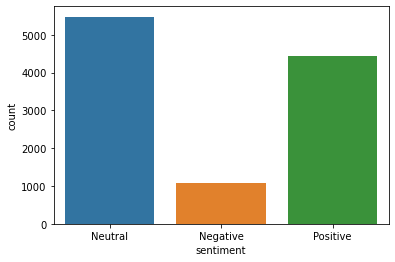

In [19]:
#count plot for postive, negtive and neutral sentiments
sns.countplot(df["sentiment"])

In [20]:
#Checking Positive, Neutral & Negative Words
positive = df[df["sentiment"] == 'Positive']
neutral = df[df["sentiment"] == 'Neutral']
negative = df[df["sentiment"] == 'Negative']

In [21]:
positive.shape, neutral.shape, negative.shape

((4449, 3), (5480, 3), (1091, 3))

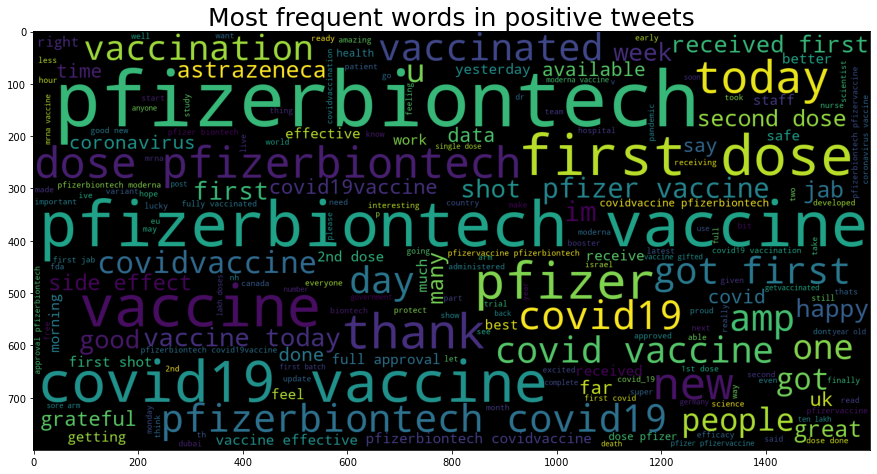

In [22]:
#Positive words
words = ' '.join([word for word in positive['text']])
plt.figure(figsize=(15,10), facecolor='None')
wordcloud = WordCloud(max_words=200, width=1600, height=800).generate(words)
plt.imshow(wordcloud)
plt.title('Most frequent words in positive tweets', fontsize=25)
plt.show()


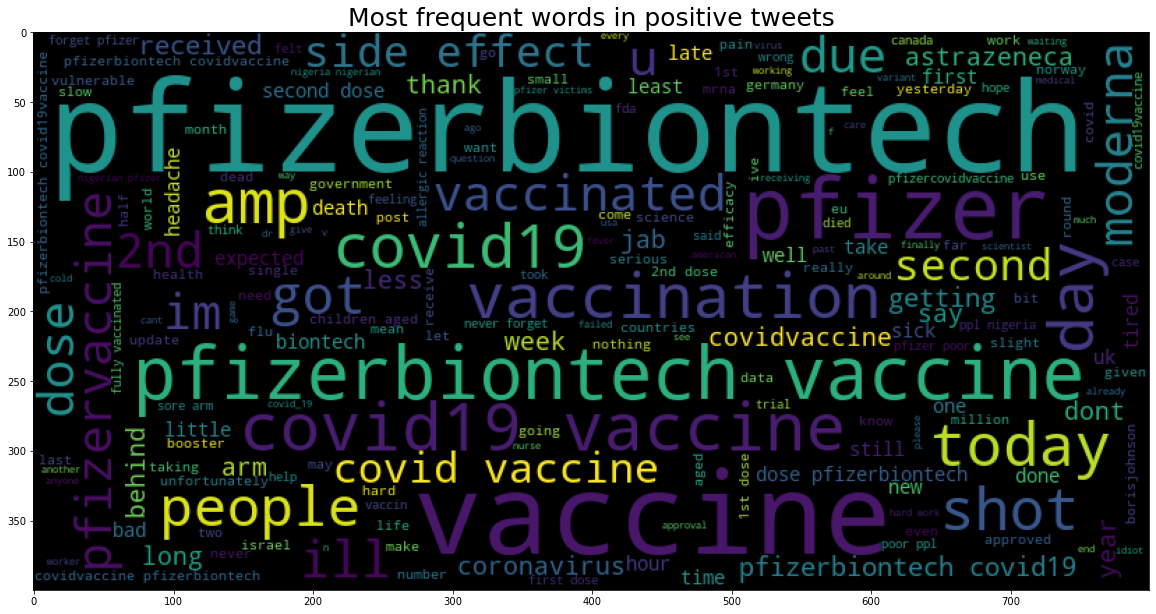

In [23]:
#Negative words
words = ' '.join([word for word in negative['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=200, width=800, height=400).generate(words)
plt.imshow(wordcloud)
plt.title('Most frequent words in positive tweets', fontsize=25)
plt.show()


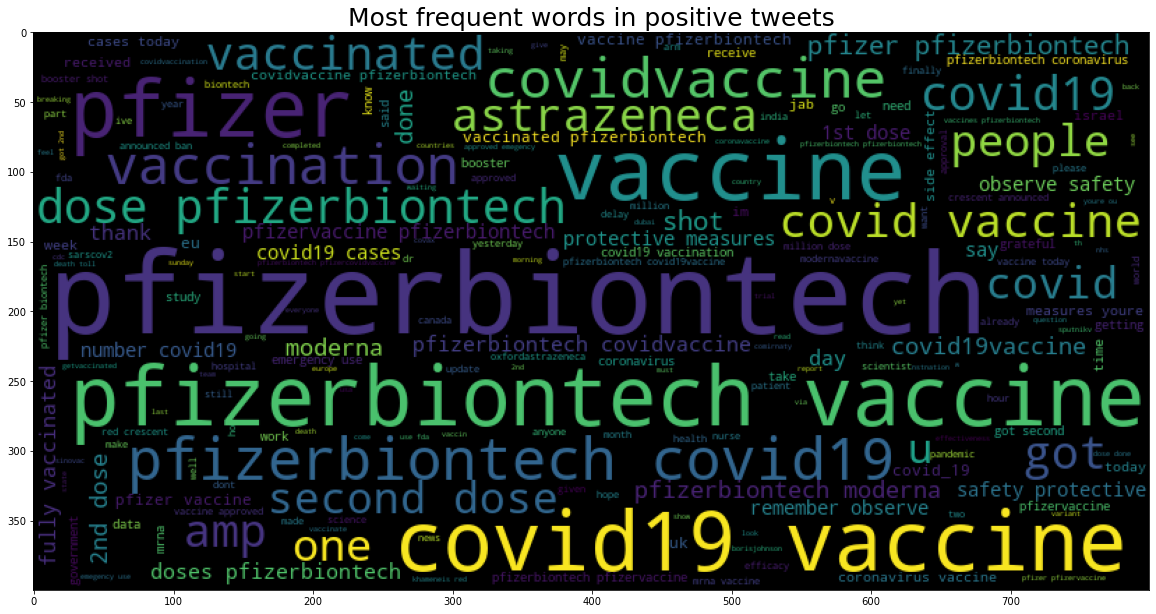

In [24]:
#Neutral words
words = ' '.join([word for word in neutral['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=200, width=800, height=400).generate(words)
plt.imshow(wordcloud)
plt.title('Most frequent words in positive tweets', fontsize=25)
plt.show()


In [25]:
X = df['text']
y = df['sentiment']

In [26]:
vec = CountVectorizer()
X = vec.fit_transform(X)

In [27]:
X

<11020x16792 sparse matrix of type '<class 'numpy.int64'>'
	with 106270 stored elements in Compressed Sparse Row format>

In [28]:
df['text']

0        folks said daikon paste could treat cytokine s...
1        world wrong side history year hopefully bigges...
2        coronavirus sputnikv astrazeneca pfizerbiontec...
3        facts immutable senator even youre ethically s...
4        explain need vaccine borisjohnson matthancock ...
                               ...                        
11015    number covid19 cases today 17 november 2021 re...
11016                            first dose pfizerbiontech
11017    number covid19 cases today 16 november 2021 re...
11018    pfizerbiontech developed new pill paxlovid inc...
11019    number covid19 cases today 15 november 2021 re...
Name: text, Length: 11020, dtype: object

In [29]:
#train test split of dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
x_train

<8816x16792 sparse matrix of type '<class 'numpy.int64'>'
	with 84899 stored elements in Compressed Sparse Row format>

In [31]:
from sklearn.svm import SVC

In [32]:
y_train = y_train.to_numpy()

In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
le = LabelEncoder()

In [35]:
y_train = le.fit_transform(y_train)

In [36]:
y_train

array([2, 1, 2, ..., 1, 2, 1])

In [37]:
svm = SVC(kernel='rbf')
model = svm.fit(x_train, y_train)
ypred = svm.predict(x_test)

In [38]:
ypred

array([1, 2, 1, ..., 1, 2, 1])

In [39]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix

In [40]:
y_test = le.fit_transform(y_test.to_numpy())

In [41]:
y_test

array([1, 2, 1, ..., 2, 2, 0])

In [42]:
accuracy_score(ypred, y_test)

0.838475499092559

In [43]:
multilabel_confusion_matrix(ypred, y_test)

array([[[1993,  167],
        [   7,   37]],

       [[ 806,    6],
        [ 316, 1076]],

       [[1253,  183],
        [  33,  735]]])

In [44]:
f1_score(ypred, y_test, average="weighted")

0.859148713967469

In [45]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [46]:
param_grid = {
    'C':[0.1, 1],
    'kernel':["linear","poly","rbf"],
    'degree':[1,3],
    'gamma':[0.01, 0.1, 0.1]
}
grid = RandomizedSearchCV(svm, param_grid, scoring="accuracy", n_iter=2 )
grid.fit(x_train, y_train)

RandomizedSearchCV(estimator=SVC(), n_iter=2,
                   param_distributions={'C': [0.1, 1], 'degree': [1, 3],
                                        'gamma': [0.01, 0.1, 0.1],
                                        'kernel': ['linear', 'poly', 'rbf']},
                   scoring='accuracy')

In [47]:
grid.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'degree': 1, 'C': 0.1}

In [48]:
grid.best_index_

1

In [49]:
grid.best_score_

0.6159266504862486

In [50]:
from sklearn.pipeline import Pipeline

In [51]:
pipe = Pipeline([('vectorizer', vec),('classifier',svm)])

In [52]:
np.unique(le.inverse_transform([0,1,2]))

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
query = ["I am very very happy that I Completed this Project"]
result = pipe.predict(query)
print(result)